# **Sentiment Analysis Using BERT**
---

Muhammad Bilal Sarwar, a master's student at the School of Interdisciplinary Engineering and Sciences (SINES), NUST, generated this file. Feel free to reach out with any queries either through comments or via email at *msarwar.mscse22sines@student.nust.edu.pk*.

In [67]:
import os
import shutil
import tarfile
import tensorflow as tf
import torch
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [68]:
# Set the current working directory to '/content'
current_folder = '/content'
os.chdir(current_folder)

# Download and extract the IMDb dataset
dataset = tf.keras.utils.get_file(
    fname="aclImdb.tar.gz",
    origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    cache_dir=current_folder,
    extract=True
)

In [69]:
dataset_path = os.path.dirname(dataset)

# Check the contents of the dataset directory
os.listdir(dataset_path)

['aclImdb.tar.gz', 'aclImdb']

In [70]:
# Dataset directory
dataset_dir = os.path.join(dataset_path, 'aclImdb')

# Check the contents of the dataset directory
os.listdir(dataset_dir)

['imdbEr.txt', 'train', 'test', 'README', 'imdb.vocab']

In [71]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['neg',
 'unsup',
 'unsupBow.feat',
 'urls_pos.txt',
 'labeledBow.feat',
 'pos',
 'urls_neg.txt',
 'urls_unsup.txt']

In [72]:
for file in os.listdir(train_dir):
    file_path = os.path.join(train_dir, file)

    if os.path.isfile(file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            first_value = f.readline().strip()
            print(f"{file}: {first_value}")
    else:
        print(f"{file}: {file_path}")

neg: /content/datasets/aclImdb/train/neg
unsup: /content/datasets/aclImdb/train/unsup
unsupBow.feat: 0 0:8 1:6 3:5 4:2 5:1 7:1 8:5 9:2 10:1 11:2 13:3 16:1 17:1 18:1 19:1 22:3 24:1 26:3 28:1 30:1 31:1 35:2 36:1 39:2 40:1 41:2 46:2 47:1 48:1 52:1 63:1 67:1 68:1 74:1 81:1 83:1 87:1 104:1 105:1 112:1 117:1 131:1 151:1 155:1 170:1 198:1 225:1 226:1 288:2 291:1 320:1 331:1 342:1 364:1 374:1 384:2 385:1 407:1 437:1 441:1 465:1 468:1 470:1 519:1 595:1 615:1 650:1 692:1 851:1 937:1 940:1 1100:1 1264:1 1297:1 1317:1 1514:1 1728:1 1793:1 1948:1 2088:1 2257:1 2358:1 2584:2 2645:1 2735:1 3050:1 4297:1 5385:1 5858:1 7382:1 7767:1 7773:1 9306:1 10413:1 11881:1 15907:1 18613:1 18877:1 25479:1
urls_pos.txt: http://www.imdb.com/title/tt0453418/usercomments
labeledBow.feat: 9 0:9 1:1 2:4 3:4 4:6 5:4 6:2 7:2 8:4 10:4 12:2 26:1 27:1 28:1 29:2 32:1 41:1 45:1 47:1 50:1 54:2 57:1 59:1 63:2 64:1 66:1 68:2 70:1 72:1 78:1 100:1 106:1 116:1 122:1 125:1 136:1 140:1 142:1 150:1 167:1 183:1 201:1 207:1 208:1 213:1 2

In [73]:
def load_dataset(directory):
    data = {"sentence": [], "sentiment": []}

    for sentiment_type in ['pos', 'neg']:
        sentiment_dir = os.path.join(directory, sentiment_type)

        for text_file in os.listdir(sentiment_dir):
            file_path = os.path.join(sentiment_dir, text_file)

            with open(file_path, "r", encoding="utf-8") as f:
                data["sentence"].append(f.read())
                data["sentiment"].append(1 if sentiment_type == 'pos' else 0)

    return pd.DataFrame.from_dict(data)

In [74]:
# Loading the dataset from the train_dir
train_df = load_dataset(train_dir)
print(train_df.head())

                                            sentence  sentiment
0  Well when watching this film late one night I ...          1
1  "The Last Wave" is one of those movies that re...          1
2  ... and I DO mean it. If not literally (after ...          1
3  First off, if you're planning on watching this...          1
4  In September 2003 36-year-old Jonny Kennedy di...          1


In [75]:
test_dir = os.path.join(dataset_dir,'test')

# Loading the dataset from the train_dir
test_df = load_dataset(test_dir)
print(test_df.head())

                                            sentence  sentiment
0  In 1937 Darryl Zanuck, who had recently moved ...          1
1  I can see that the ratings for this film aren'...          1
2  I rank OPERA as one of the better Argento film...          1
3  Alright, so maybe the impersonations of Jay Le...          1
4  If you're actually reading this review, I give...          1


In [76]:
sentiment_counts = train_df['sentiment'].value_counts()

fig =px.bar(x= {0:'Negative',1:'Positive'},
			y= sentiment_counts.values,
			color=sentiment_counts.index,
			color_discrete_sequence = px.colors.qualitative.Dark24,
			title='<b>Sentiments Counts')

fig.update_layout(title='Sentiments Counts',
				xaxis_title='Sentiment',
				yaxis_title='Counts',
				template='plotly_dark')

# Show the bar chart
fig.show()
pyo.plot(fig, filename = 'Sentiments Counts.html', auto_open = True)


'Sentiments Counts.html'

In [17]:
def text_cleaning(text):
    # Parse HTML content using BeautifulSoup
    soup = BeautifulSoup(text, "html.parser")

    # Remove text within square brackets and the brackets themselves
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"

    # Remove characters that do not match the defined pattern
    text = re.sub(pattern, '', text)
    return text

In [18]:
# Training dataset after cleaning
train_df['Cleaned_sentence'] = train_df['sentence'].apply(text_cleaning).tolist()
# Testing dataset after cleaning
test_df['Cleaned_sentence'] = test_df['sentence'].apply(text_cleaning)


<ipython-input-17-ccf2af4d58fd>:3: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

<ipython-input-17-ccf2af4d58fd>:3: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [19]:
# Function to generate word cloud
def generate_wordcloud(text,Title):
	all_text = " ".join(text)
	wordcloud = WordCloud(width=800,
						height=400,
						stopwords=set(STOPWORDS),
						background_color='black').generate(all_text)
	plt.figure(figsize=(10, 5))
	plt.imshow(wordcloud, interpolation='bilinear')
	plt.axis("off")
	plt.title(Title)
	plt.show()

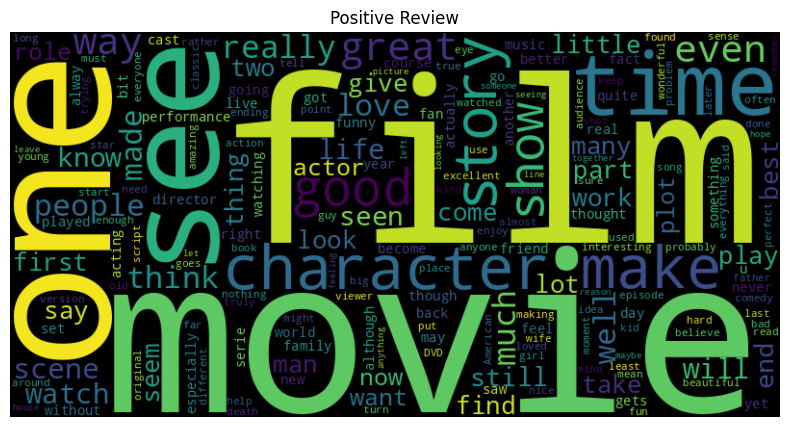

In [20]:
positive = train_df[train_df['sentiment']==1]['Cleaned_sentence'].tolist()
generate_wordcloud(positive,'Positive Review')

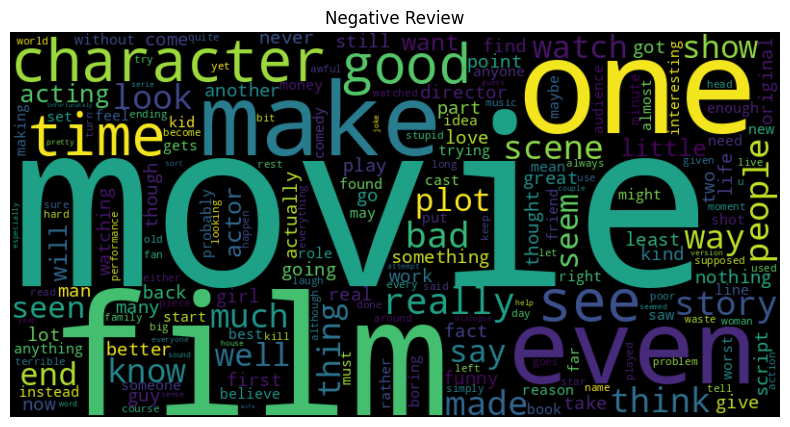

In [21]:
negative = train_df[train_df['sentiment']==0]['Cleaned_sentence'].tolist()
generate_wordcloud(negative,'Negative Review')

In [22]:
# Training data
#Reviews = "[CLS] " +train_df['Cleaned_sentence'] + "[SEP]"
Reviews = train_df['Cleaned_sentence']
Target = train_df['sentiment']

# Test data
#test_reviews = "[CLS] " +test_df['Cleaned_sentence'] + "[SEP]"
test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']

In [23]:
x_val, x_test, y_val, y_test = train_test_split(test_reviews,
													test_targets,
													test_size=0.5,
													stratify = test_targets)

In [24]:
#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [26]:
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

In [27]:
k = 0
print('Training Comments -->>',Reviews[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',Target[k])

Training Comments -->> Well when watching this film late one night I was simple amazed by it's greatness Fantastic script, great acting, costumes and special effects, and the plot twists, wow In fact if you can see the ending coming you should become a writer yourselfGreat, I would recommend this film to anyone, especially if I dont like them muchTerrific

Input Ids -->>
 tf.Tensor(
[  101  2092  2043  3666  2023  2143  2397  2028  2305  1045  2001  3722
 15261  2011  2009  1005  1055  2307  2791 10392  5896  1010  2307  3772
  1010 12703  1998  2569  3896  1010  1998  1996  5436 21438  1010 10166
  1999  2755  2065  2017  2064  2156  1996  4566  2746  2017  2323  2468
  1037  3213  4426 17603  4017  1010  1045  2052 16755  2023  2143  2000
  3087  1010  2926  2065  1045  2123  2102  2066  2068  2172  3334  3089
  8873  2278   102     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0

In [28]:
# Intialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [30]:
torch.cuda.is_available()

True

In [31]:
def get_default_device():
    """Picking GPU if available or else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [32]:
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    Target,
    validation_data=(
        [X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']], y_val),
        batch_size=32,
        epochs=3
    )

Epoch 1/3
782/782 [==============================] - 791s 928ms/step - loss: 0.3403 - accuracy: 0.8470 - val_loss: 0.2682 - val_accuracy: 0.8856
Epoch 2/3
782/782 [==============================] - 722s 924ms/step - loss: 0.2009 - accuracy: 0.9216 - val_loss: 0.2739 - val_accuracy: 0.8852
Epoch 3/3
782/782 [==============================] - 722s 924ms/step - loss: 0.1091 - accuracy: 0.9610 - val_loss: 0.3553 - val_accuracy: 0.8759


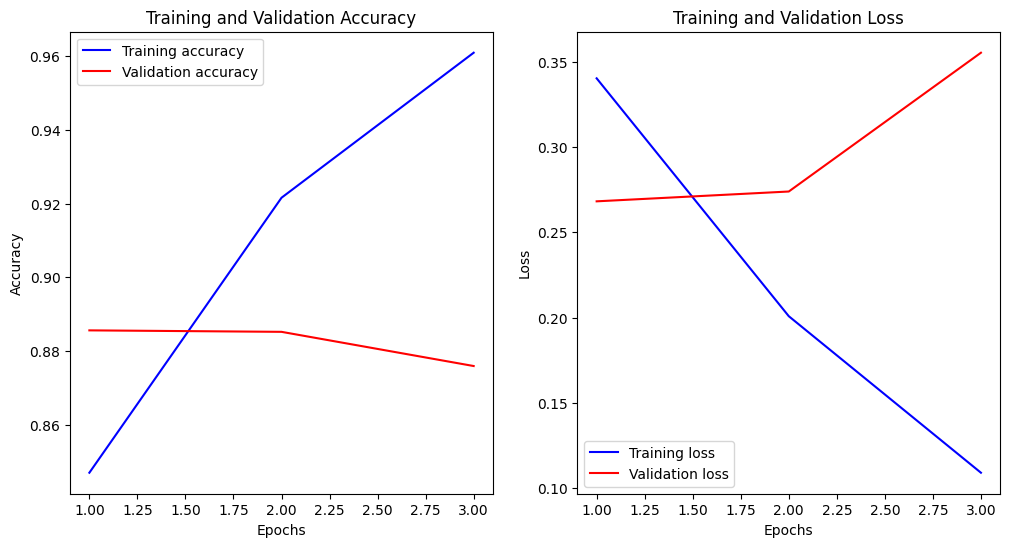

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

In [37]:
#Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
	y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')


391/391 [==============================] - 105s 268ms/step - loss: 0.3558 - accuracy: 0.8760
Test loss: 0.35581186413764954, Test accuracy: 0.8759999871253967


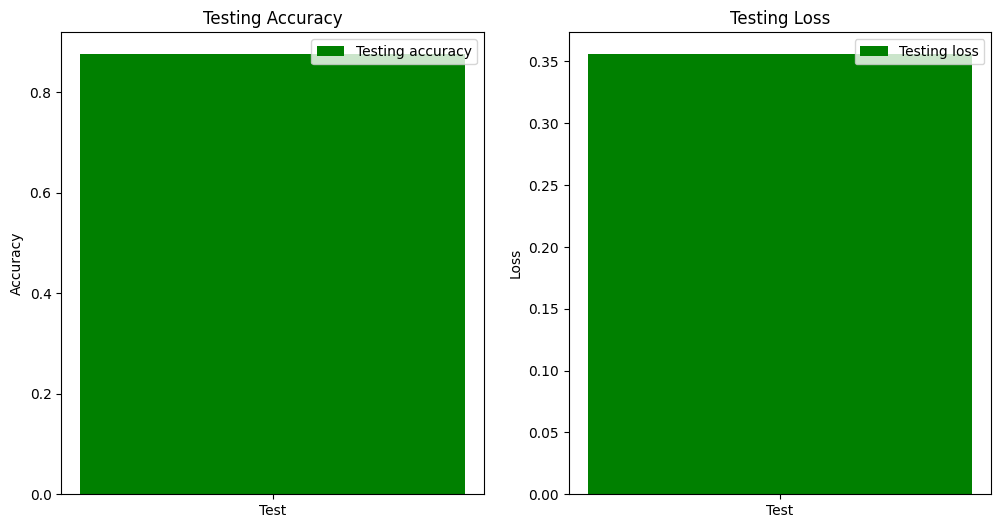

In [41]:
plt.figure(figsize=(12, 6))

# Plot testing accuracy
plt.subplot(1, 2, 1)
plt.bar(['Test'], [test_accuracy], color='g', label='Testing accuracy')
plt.title('Testing Accuracy')
plt.ylabel('Accuracy')
plt.legend()

# Plot testing loss
plt.subplot(1, 2, 2)
plt.bar(['Test'], [test_loss], color='g', label='Testing loss')
plt.title('Testing Loss')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

In [42]:
#Saveing the model and tokenizer to the local folder
path = 'path-to-save'
# Save tokenizer
tokenizer.save_pretrained(path +'/Tokenizer')

# Save model
model.save_pretrained(path +'/Model')


In [43]:
# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer')

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model')

Some layers from the model checkpoint at path-to-save/Model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at path-to-save/Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [44]:
pred = bert_model.predict(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

# pred is of type TFSequenceClassifierOutput
logits = pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

label = {
	1: 'positive',
	0: 'Negative'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print('Predicted Label :', pred_labels[:10])
print('Actual Label :', Actual[:10])

391/391 [==============================] - 106s 264ms/step
Predicted Label : ['Negative', 'positive', 'positive', 'positive', 'positive', 'Negative', 'Negative', 'Negative', 'positive', 'Negative']
Actual Label : ['Negative', 'positive', 'positive', 'positive', 'positive', 'Negative', 'Negative', 'Negative', 'positive', 'Negative']


In [56]:
c_report = classification_report(Actual, pred_labels)
print("Classification Report: \n", c_report)

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.84      0.93      0.88      6250
    positive       0.92      0.82      0.87      6250

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500



In [46]:
def Get_sentiment(Review, Tokenizer=bert_tokenizer, Model=bert_model):
	# Convert Review to a list if it's not already a list
	if not isinstance(Review, list):
		Review = [Review]

	Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review,
																			padding=True,
																			truncation=True,
																			max_length=128,
																			return_tensors='tf').values()
	prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])

	# Use argmax along the appropriate axis to get the predicted labels
	pred_labels = tf.argmax(prediction.logits, axis=1)

	# Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
	pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
	return pred_labels

In [49]:
Review ='''Bahubali is a blockbuster Indian movie that was released in 2015.
It is the first part of a two-part epic saga that tells the story of a legendary hero who fights for his kingdom and his love.
The movie has received rave reviews from critics and audiences alike for its stunning visuals,
spectacular action scenes, and captivating storyline.'''
Get_sentiment(Review)


1/1 [==============================] - 0s 50ms/step


['positive']

In [50]:
Review ='''Bahubali is a flop Indian movie that was released in 2015. It is the first part of a two-part epic saga that poorly narrates the story of a forgettable hero who fails
to make any impact for his kingdom and his love . The movie has received harsh criticism from critics and audiences alike for its lackluster visuals, uninspiring action scenes,
and a dull storyline.'''
Get_sentiment(Review)


1/1 [==============================] - 0s 50ms/step


['Negative']